In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm
my_cmap = plt.cm.jet
my_cmap.set_under('white')

In [4]:
from functools import partial
from scipy.misc import central_diff_weights

def richardson(f, x, n, h):
    """
    Richardson's Extrapolation
    """
    d = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        d[i, 0] = 0.5 * (f(y=x + h) - f(y=x - h)) / h
        p4 = 1  # values of 4^j
        for j in range(1, i + 1):
            p4 = 4 * p4
            d[i, j] = d[i, j-1] + (d[i, j-1] - d[i-1,j-1]) / ( p4 - 1 )
        h = 0.5 * h
    return d[n, n]

def n_order_scheme(f, x, h, n, *args, **kwargs):
    """
    Used in experiments
    """
    weights = central_diff_weights(n)
    grad_f = 0
    for i, j in enumerate(np.arange(-n // 2, n // 2) + 1):
        grad_f += weights[i] * f(y=x + j * h)
    return grad_f / h

def partial_function(f, x, i, y):
    return f((x[:i] + [y] + x[i + 1:]))

def compute_gradient_of_vector_function(f, x, n, h, num_func_evals=10):
    dim = len(x)
    partial_derivatives = []
    number_of_evaluations = 0
    for i in range(dim):
        number_of_evaluations += 4 # n * 2
        partial_derivatives.append(
            np.mean([n_order_scheme(partial(partial_function, f=f, x=x, i=i), x[i], n=n, h=h) 
                     for _ in range(num_func_evals)])
        )
    return partial_derivatives, number_of_evaluations

In [7]:
def rosenbrock(X):
    x = X[0]
    y = X[1]
    a = 1. - x
    b = y - x*x
    return a*a + b*b*100.

def rosenbrock_grad(X):
    x = X[0]
    y = X[1]
    dx = 400 * x**3 - 400 * x * y + 2 * x - 2
    dy = 200 * (y - x**2)
    return [dx, dy]

In [8]:
import os
import sys
sys.path.append("..")

In [9]:
from model import YModel, OptLoss
from utils import sample_noise, iterate_minibatches, generate_data
from pyro import distributions as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

In [10]:
y_sampler = YModel()

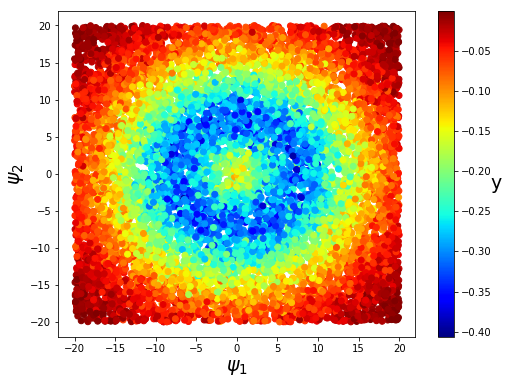

In [11]:
mu = dist.Uniform(-20, 20).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 100]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})

y = y_sampler.condition_sample()
c = OptLoss.SigmoidLoss(y, 5, 10).detach().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(mu[:,0], mu[:, 1], c=c, cmap=my_cmap)
cbar = plt.colorbar()

plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('y', rotation=360, fontsize=19)
plt.show()

In [12]:
# !pip install git+https://github.com/mariogeiger/hessian.git

In [13]:
from hessian import hessian as hessian_calc

In [14]:
NUM_RUNS_PER_CALL = 100
def optimized_function(mu, N=NUM_RUNS_PER_CALL):
    mu = torch.tensor(mu).float().repeat(1, 2)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu), N]))
    y_sampler.make_condition_sample({'mu': mu, 'X': x_r})

    y = y_sampler.condition_sample()
    return OptLoss.SigmoidLoss(y, 5, 10).mean().item()

In [15]:
def optimized_function_grad_hessian(mu, N=NUM_RUNS_PER_CALL):
    mu = torch.tensor(mu, requires_grad=True, dtype=torch.float)
    x_r = y_sampler.x_dist.sample(torch.Size([len(mu.view(1, 2)), N]))
    y_sampler.make_condition_sample({'mu': mu.view(1, 2), 'X': x_r})

    y = y_sampler.condition_sample()
    L = OptLoss.SigmoidLoss(y, 5, 10).mean()
    h = hessian_calc(L, mu)
    L.backward()
    
    return mu.grad, h

In [16]:
def rotate_vector(x, angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c)))
    return R.dot(x)

In [27]:
from tqdm import tqdm_notebook as tqdm
def optimization_procedure(optimized_function, mu, lr=1., h=0.01, n=11, num_func_evals=10, N=100):
    grads = []
    mus = []
    for i in tqdm(range(N)):
        grad_new, num_evaluations = compute_gradient_of_vector_function(f=optimized_function,
                                                                        x=mu.tolist(), 
                                                                        n=n, 
                                                                        h=h, 
                                                                        num_func_evals=num_func_evals)
        grad = np.array(grad_new) / np.linalg.norm(np.array(grad_new))
        mu = mu - lr * grad

        grads.append(grad)
        mus.append(mu)
        
    return np.array(mus), np.array(grads)

In [28]:
mu_init = np.array([0., 0.])
mus_1, grads_1 = optimization_procedure(optimized_function=optimized_function, 
                                        mu=mu_init, lr=1e-1, N=10000)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [29]:
mu_init = np.array([0., 0.])
mus_2, grads_2 = optimization_procedure(optimized_function=optimized_function, 
                                        mu=mu_init, lr=1e-1, N=10000)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [30]:
mu_init = np.array([15., 15.])
mus_3, grads_3 = optimization_procedure(optimized_function=optimized_function, 
                                        mu=mu_init, lr=1e-1, N=10000)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
mu_init = np.array([15., -15.])
mus_4, grads_4 = optimization_procedure(optimized_function=optimized_function, 
                                        mu=mu_init, lr=1e-1, N=10000)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



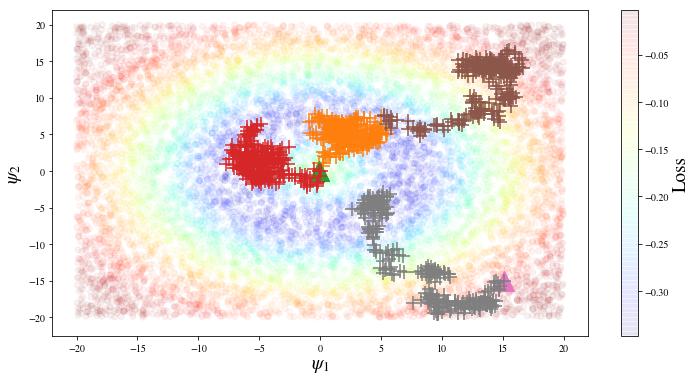

In [32]:
plt.figure(figsize=(12, 6))

mu = dist.Uniform(-20, 20).sample([10000, 2])
x_r = y_sampler.x_dist.sample(torch.Size([len(mu), 1000]))
y_sampler.make_condition_sample({'mu': mu, 'X': x_r})
samples = y_sampler.condition_sample()
rs = OptLoss.SigmoidLoss(samples, 5, 10)

plt.scatter(mu[:, 0], mu[:, 1], c=rs,  cmap=my_cmap, alpha=0.05)
cbar = plt.colorbar()
plt.xlabel(f"$\psi_1$", fontsize=19)
plt.ylabel(f"$\psi_2$", fontsize=19)
cbar.set_label('Loss', rotation=90, fontsize=19)

each_mu = 40
# for index, mu_path in enumerate(opt_mu):
plt.scatter(mus_1[0, 0], mus_1[0, 1], marker='^', s=400)
plt.scatter(mus_1[::each_mu, 0], mus_1[::each_mu, 1], marker='+', s=200)

plt.scatter(mus_2[0, 0], mus_2[0, 1], marker='^', s=400)
plt.scatter(mus_2[::each_mu, 0], mus_2[::each_mu, 1], marker='+', s=200)

plt.scatter(mus_3[0, 0], mus_3[0, 1], marker='^', s=400)
plt.scatter(mus_3[::each_mu, 0], mus_3[::each_mu, 1], marker='+', s=200)

plt.scatter(mus_4[0, 0], mus_4[0, 1], marker='^', s=400)
plt.scatter(mus_4[::each_mu, 0], mus_4[::each_mu, 1], marker='+', s=200)
plt.grid()
plt.grid()

-0.2781911790370941

In [34]:
optimized_function(mus_2[-1], N=10000)

-0.2872319221496582

In [35]:
optimized_function(mus_3[-1], N=10000)

-0.2346062809228897

In [36]:
optimized_function(mus_4[-1], N=10000)

-0.31274843215942383

## Biased gradients(solved)

Generally, our numerical derivative is a function of noisy inputs. We are making two assumptions: noise terms are independent(which might not be true) and mathematical expectation of noise is zero.

$$f_x' \approx \frac{f(x + h, \epsilon_1, y, \epsilon_2) - f(x, \epsilon_3, y, \epsilon_4)}{h}, ~~~\epsilon_{\{1,2,3, 4\}} \sim p(\epsilon), ~~\mathrm{E}~\epsilon = 0$$


____________________________________________________________________________________

```
Let's take one term:

$$f(x + h, \epsilon_1, y, \epsilon_2) = f(x + h, y) + \vec{\epsilon} \nabla f(x + h, y) + \vec{\epsilon}^{T} \nabla^2 f(x + h, y) \vec{\epsilon} + o(|| \epsilon ||^3)$$


Mathematical expectation over noise:

$$\mathrm{E} f(x + h + \epsilon_1, y + \epsilon_2) = f(x + h, y) + \mathrm{tr} \left( \mathrm{E}(\epsilon \epsilon^T) \nabla^2 f \right)  + \dots $$



```

In [17]:
mu_init = np.array([-17., -17.])

def investigation_of_biased_grads(mu):
    lr = 0.1
    mus = []
    grads = []
    grads_true = []
    hessians_true = []
    grad = np.zeros(2)
    for i in (range(100)):
        grad_new, num_evaluations = compute_gradient_of_vector_function(optimized_function,
                                                                        mu.tolist(), 
                                                                        n=11, 
                                                                        h=.01)
        mu_grad, mu_hessian = optimized_function_grad_hessian(mu)
        grad = np.array(grad_new)
        mu = mu - lr * grad

        grads.append(grad)
        grads_true.append(mu_grad.detach().cpu().numpy())
        hessians_true.append(mu_hessian.detach().cpu().numpy())

        mus.append(mu)

    grads = np.array(grads)
    grads_true = np.array(grads_true)
    hessians_true = np.array(hessians_true)
    
    return grads, grads_true, hessians_true

### Investigation of biased grads

1. Estimate gradients multiple times at some point
2. Fit bias of gradient in y-dimension as linear function of bias in x-dimension: bias $\nabla_y f  = k \nabla_x + c$
3. Calculate eigenvector of hessian
4. visualize $\arctan(\mathrm{eigenvector})$ and $\arctan(k)$

In [20]:
from sklearn.linear_model import TheilSenRegressor
grad_rotations = []
grad_x_median_shift = []
grad_y_median_shift = []
hessians_all = []
hessian_eigen_vector_directions_1 = []
hessian_eigen_vector_directions_2 = []
hessian_eigen_value_directions_1 = []
hessian_eigen_value_directions_2 = []
hessian_traces = []

for angle in tqdm(np.linspace(0, 90, 2)):
    grads, grads_true, hessians_true = investigation_of_biased_grads(rotate_vector(mu_init, angle))
    eival, eivec = np.linalg.eig(hessians_true)
    linreg = TheilSenRegressor().fit((grads[:, 1] - grads_true[:, 1]).reshape(-1, 1), grads[:, 0] - grads_true[:, 0])
    
    grad_x_median_shift.append(np.median(grads[:, 0] - grads_true[:, 0]))
    grad_y_median_shift.append(np.median(grads[:, 1] - grads_true[:, 1]))


    grad_rotation = np.arctan(linreg.coef_[0])
    grad_rotations.append(grad_rotation)
    
    hessian_eigen_vector_directions_1.append(np.median(np.arctan(eivec[:, 1, 0] / eivec[:, 0, 0])))
    hessian_eigen_vector_directions_2.append(np.median(np.arctan(eivec[:, 1, 1] / eivec[:, 0, 1])))
    hessian_eigen_value_directions_1.append(np.median(eival[:, 0]))
    hessian_eigen_value_directions_2.append(np.median(eival[:, 1]))
    
    hessian_traces.append(np.median(hessians_true[:, 0, 0] + hessians_true[:, 1, 1]))
    hessians_all.append(np.median(hessians_true, axis=0))

hessians_all = np.concatenate(hessians_all).reshape(-1, 2, 2)

100%|██████████| 2/2 [00:27<00:00, 14.02s/it]


In [21]:
import matplotlib

# Customize††matplotlib
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)
matplotlib.rcParams['pdf.fonttype'] = 3
matplotlib.rcParams['ps.fonttype'] = 3

Text(0, 0.5, 'Direction(arctan2) of first eigenvector of hessian')

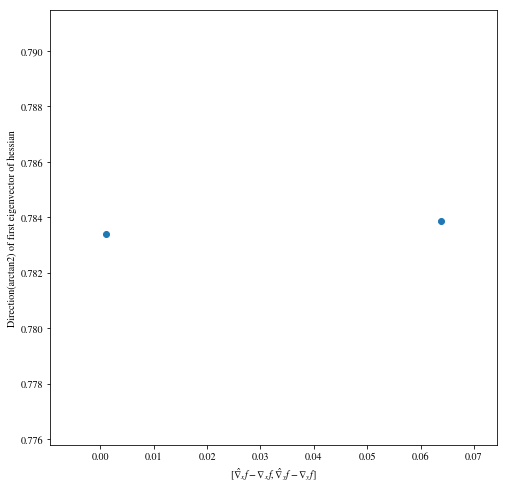

In [22]:
plt.figure(figsize=(8, 8))
plt.scatter(grad_rotations, hessian_eigen_vector_directions_1)
plt.xlabel('$ [ \hat{\\nabla}_x f -  \\nabla_x f, \hat{\\nabla}_y f -  \\nabla_y f ] $')
plt.ylabel('Direction(arctan2) of first eigenvector of hessian')

Text(0, 0.5, 'Direction(arctan2) of second eigenvector of hessian')

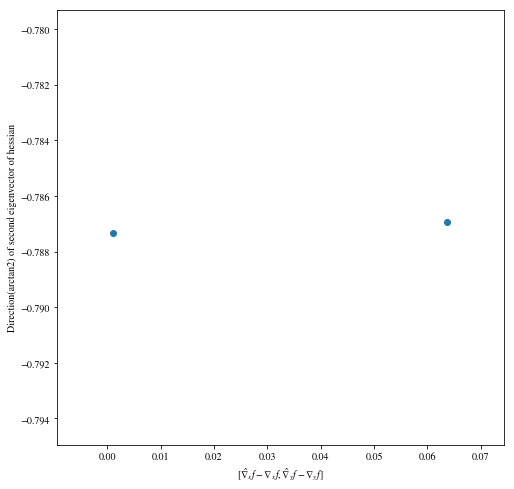

In [23]:
plt.figure(figsize=(8, 8))
plt.scatter(grad_rotations, hessian_eigen_vector_directions_2)
plt.xlabel('$ [ \hat{\\nabla}_x f -  \\nabla_x f, \hat{\\nabla}_y f -  \\nabla_y f ] $')
plt.ylabel('Direction(arctan2) of second eigenvector of hessian')

Text(0, 0.5, 'hessian trace')

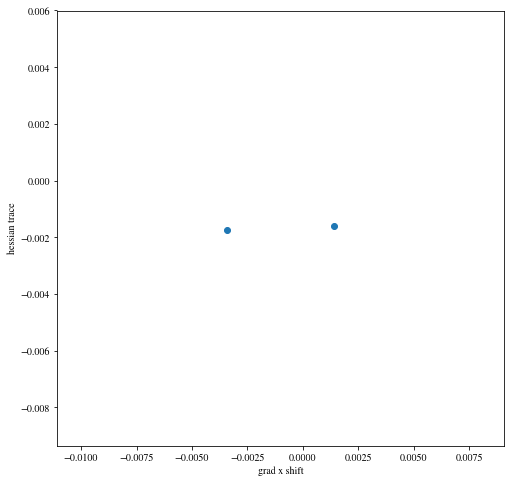

In [24]:
plt.figure(figsize=(8, 8))
hessian_traces_med = list(map(np.median, hessian_traces))
plt.scatter(grad_x_median_shift, hessian_traces_med)
plt.xlabel('grad x shift')
plt.ylabel('hessian trace')

Text(0, 0.5, 'hessian xy')

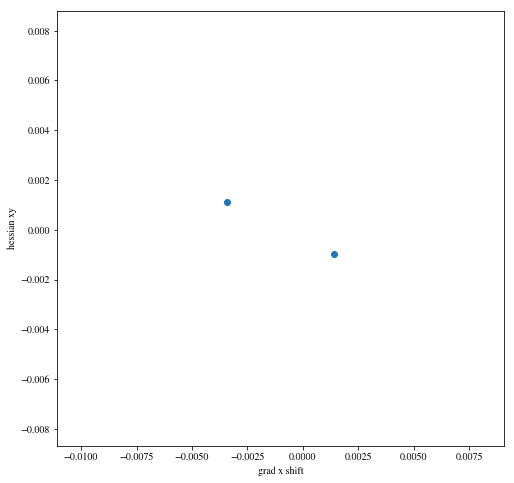

In [25]:
plt.figure(figsize=(8, 8))
plt.scatter(grad_x_median_shift, hessians_all[:, 0, 1])
plt.xlabel('grad x shift')
plt.ylabel('hessian xy')

Text(0, 0.5, 'hessian xy')

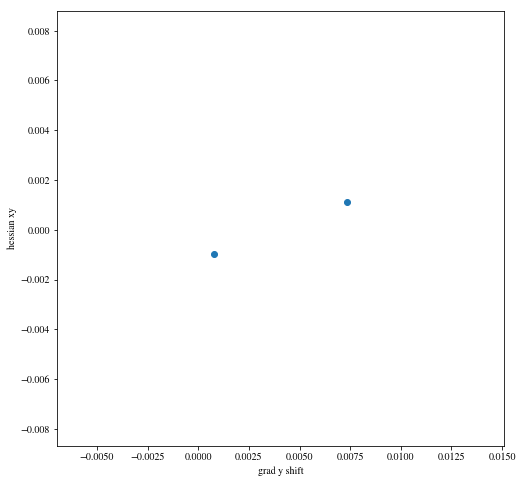

In [26]:
plt.figure(figsize=(8, 8))
plt.scatter(grad_y_median_shift, hessians_all[:, 0, 1])
plt.xlabel('grad y shift')
plt.ylabel('hessian xy')